<table style="width:100%" border="0">
    <col width="20%">
    <col width="60%">
    <col width="20%">
    <tr></tr>
    <tr>
        <th style="text-align:left"><img src="Images/UNAM_logo.jpg" width="150px"></th>
        <th style="text-align:center"><span style="font-size:220%">Sistema espín - boson</span><br/><br/><span style="font-size:150%">Alonso Torres Edgar Giovanni y Negrete Aragón Sebastián</span><br/><br/><span style="font-size:120%">Física Computacional, Facultad de Ciencias, 2018-1</span><br/><span style="font-size:120%">Universidad Nacional Autónoma de México</span></th>  
        <th style="text-align:right"><img src="Images/LogoCiencias.jpg" width="170px"></th>
    </tr>
</table>

## Introducción

Se implementan rutinas para simular numéricamente el sistema bipartito espín-boson.

In [1]:
using PyPlot

## Hamiltoniano

El hamiltoniano describe la interacción entre un sistema atómico de dos niveles y un bosón que en el caso de la óptica cuántica sería un fotón. La expresión analítica es:

$$\mathcal{H}=\frac{\Delta}{2}\sigma_{z}+\hbar\omega_{0}\left(a^{\dagger}a+\frac{1}{2}\right)+g(\sigma_{+}a+\sigma_{-}a^{\dagger})+g(\sigma_{+}a^{\dagger}+\sigma_{-}a)$$

En donde:

* $\Delta$ es la frecuencia de espín: en este notebook se tratará con qubits.
* $\omega_{0}$ es la frecuencia del campo.
* $g$ el acoplamiento.
* $\sigma_{z}$, $\sigma_{\pm}=\sigma_{x}\pm i\sigma_{y}$ son las matriz de Pauli.
* $a$, $a^{\dagger}$ los operadores de aniquilación y creación.

El primer término de este hamiltoniano se debe al sistema atómico, el segundo al bosón (notamos la relación directa con lo visto en el hamiltoniano del oscilador armónico cuántico) y los últimos dos representan la interacción.

Según lo reportado en trabajos del tema el hamiltoniano no es integrable de manera analítica. Para hacer aproximaciones numéricas requerimos truncar el espacio dimensional infinito de estados del oscilador usando una base finita de estados etiquetados por el número asociado a los niveles energéticos con los que trabajan con los que trabajan los operadores de creacion y destrucción.

Para simular este hamiltoniano se necesita que todos los operadores estén en el mismo espacio, así que se utiliza el producto tensorial, en particular el producto de Kronecker, así que el hamiltoniano queda como sigue

$$\mathcal{H}=\frac{\Delta}{2}\sigma_{z}\otimes\mathbf{I}_{N}+\mathbf{I}_{2}\otimes\hbar\omega_{0}\left(a^{\dagger}a+\frac{1}{2}\mathbf{I}_{N}\right)+g(\sigma_{+}\otimes a+\sigma_{-}\otimes a^{\dagger})+g(\sigma_{+}\otimes a^{\dagger}+\sigma_{-}\otimes a)$$

Se trabaja en unidades naturales, i.e. con $\hbar=1$. Para construir el hamiltoniano empezamos con los operadores de creación y aniquilación, se trabaja con el de creación y pues el de aniquilación es su transpuesto conjugado.

Si representamos a los estados del campo por $\left|n\right>$, $n=0,1,\dots$ sabemos que

$$a^{\dagger}\left|n\right>=\sqrt{n+1}\left|n+1\right>\hspace{2cm}(1)$$

los estados del campo se representan mediante vectores columna, es decir $\left|0\right>=(1,0,\dots)^{T}$, $\left|1\right>=(0,1,\dots)^{T}$ y en general $\left|n\right>$ es el vector columna con 1 en la entrada $n+1$ y ceros en el resto, por supuesto para simularlo se necesitan tomar un número finito $N$ de modos del campo. Así pues, con esta representación y la ecuación 1 se tiene que el operador de creación $a^{\dagger}$ tiene la representación matricial siguiente

$$[a^{\dagger}]_{i,j}=\sqrt{j\:}\delta_{i,j+1}\:\longrightarrow\:a^{\dagger}=\left(\begin{array}{cccccc}0 & 0 & 0 & \cdots & 0 & \cdots\\\sqrt{1} & 0 & 0 & \cdots & 0 & \cdots\\0 & \sqrt{2} & 0 & \cdots & 0 & \cdots\\0 & 0 & \sqrt{3} & \cdots & 0 & \cdots\\\vdots & \vdots & \vdots & \ddots & \vdots & \cdots\\0 & 0 & 0 & \cdots & \sqrt{n} & \cdots\\\vdots & \vdots & \vdots & \vdots & \vdots & \ddots\end{array}\right)\hspace{2cm}(2)$$

De igual manera para implementar se hace con una matriz de $N\times N$.

In [2]:
"""Crea estados del campo, `ket```(N,n)`` utiliza dos argumentos, ``N`` es la dimensión que se le da al campo bosónico mientras que ``n`` representa el ``n``-ésimo estado del campo."""

function ket(N,n)
    k = zeros(N)   # Primero se crea un vector con todas las entradas iguales a 0.
    k[n+1] = 1       # Se cambia la n+1-ésima entrada por 1.
    return k
end;

In [3]:
"""Construye la matriz del operador de creación, `creation```(N)`` crea una matriz de tamaño ``N\\times N.``"""

function creation(N)
    a = zeros(N-1)       # Se crea un vector columna de tamaño N-1.
    for i in 1:N-1
        a[i] = sqrt(i)   # La i-ésima entrada del vector es la raíz cuadrada de i, ecuación 2.
    end
    return diagm(a,-1)   # Se crea una matriz de ceros de N por N excepto la diagonal inferior a la diagonal principal que será el vector construido.
end;

Por ejemplo, la matriz para una dimensión igual a 5

In [4]:
a = creation(5)'   # La matriz del operador de aniquilación es la transpuesta conjugada de la de creación

5×5 Array{Float64,2}:
 0.0  1.0  0.0      0.0      0.0
 0.0  0.0  1.41421  0.0      0.0
 0.0  0.0  0.0      1.73205  0.0
 0.0  0.0  0.0      0.0      2.0
 0.0  0.0  0.0      0.0      0.0

Entonces se construye el hamiltoniano, utilizando el producto de Kronecker

In [5]:
"""Crea el hamiltoniano del sistema espín-boson, `Hsp```(N,Delta,w0,g)`` recibe a ``N``: la dimensión del espacio del campo, ``Delta``: la frecuencia de espín, ``w0``: la frecuencia del campo y el acoplamiento ``g``."""

function Hsp(N,Delta,w0,g)
    Pauliz = [1.0 0;0 -1]   # Matriz de Pauli sigma_z.
    Paulip = [0.0 2;0 0]    # Matriz sigma_x+i*sigma_y.
    Paulim = [0.0 0;2 0]    # Matriz sigma_x-i*sigma_y.
    a = creation(N)'        # Se crea el operador de aniquilación.
    hh = kron(eye(2),w0*(a'*a+0.5*eye(N)))    # Parte del hamiltoniano, la que tiene la frecuencia del campo.
    hr = kron(Paulip,a)+kron(Paulim,a')       # La parte rotante del hamiltoniano.
    ha = kron(Paulip,a')+kron(Paulim,a)       # La parte antirotante del hamiltoniano.
    h = (Delta/2)*kron(Pauliz,eye(N))+hh+g*hr+g*ha   # Hamiltoniano completa, la parte con la frecuencia de espín y la suma de los anteriores.
    return h
end;

Por ejemplo para el sistema con frecuencia de qubit, de campo y acoplamiento igual a 2, con dimensión 100 para el campo

In [6]:
H1 = Hsp(100,2,2,2)   # Hamiltoniano

200×200 Array{Float64,2}:
 2.0  0.0  0.0  0.0   0.0   0.0   0.0  …    0.0    0.0    0.0    0.0    0.0
 0.0  4.0  0.0  0.0   0.0   0.0   0.0       0.0    0.0    0.0    0.0    0.0
 0.0  0.0  6.0  0.0   0.0   0.0   0.0       0.0    0.0    0.0    0.0    0.0
 0.0  0.0  0.0  8.0   0.0   0.0   0.0       0.0    0.0    0.0    0.0    0.0
 0.0  0.0  0.0  0.0  10.0   0.0   0.0       0.0    0.0    0.0    0.0    0.0
 0.0  0.0  0.0  0.0   0.0  12.0   0.0  …    0.0    0.0    0.0    0.0    0.0
 0.0  0.0  0.0  0.0   0.0   0.0  14.0       0.0    0.0    0.0    0.0    0.0
 0.0  0.0  0.0  0.0   0.0   0.0   0.0       0.0    0.0    0.0    0.0    0.0
 0.0  0.0  0.0  0.0   0.0   0.0   0.0       0.0    0.0    0.0    0.0    0.0
 0.0  0.0  0.0  0.0   0.0   0.0   0.0       0.0    0.0    0.0    0.0    0.0
 0.0  0.0  0.0  0.0   0.0   0.0   0.0  …    0.0    0.0    0.0    0.0    0.0
 0.0  0.0  0.0  0.0   0.0   0.0   0.0       0.0    0.0    0.0    0.0    0.0
 0.0  0.0  0.0  0.0   0.0   0.0   0.0       0.0    0.0    0.0 

Entonces se puede checar que es hermitiano al buscar el máximo y minímo valor de la diferencia entre hamiltoniano y su transpuesto conjugado

In [7]:
maximum(H1-H1'),minimum(H1-H1')   # El hamiltoniano es hermitiano

(0.0, 0.0)

## Estados coherentes

Para la implementación de estados coherentes $\left|\alpha\right>$ se utiliza la siguiente fórmula

$$\left|\alpha\right>=e^{-\left|\alpha\right|^2/2}\sum_{n=0}^{\infty}\frac{\alpha^{n}}{\sqrt{n!}}\left|n\rangle\right.\hspace{2cm}(3)$$

que en lugar de ser una serie, la truncamos hasta la dimensión del campo $N$.

In [8]:
"""Esta función da los estados coherentes del campo, `coherent```(N,alpha)`` es el estado coherente ``alpha`` en el espacio del campo de dimensión ``N``."""

function coherent(N,alpha)
    s = 0      # Se define la variable local s a la que se le agregaran los términos de la suma del estado coherente.
    for n in 0:N-1   # La suma corre desde el estado base 0 al estado N-1.
        s += alpha^n*ket(N,n)/sqrt(factorial(float(n)))   # Se van sumando los términos de la fórmula 3.
    end
    s *= exp(-abs(alpha)^2*0.5)   # Finalmente se multiplica por la exponencial.
    return s
end;

Por ejemplo, el estado coherente $\pi$

In [9]:
alpha = coherent(100,pi)   # Estado coherente pi

100-element Array{Float64,1}:
 0.00719188 
 0.022594   
 0.0501912  
 0.0910367  
 0.143      
 0.20091    
 0.257677   
 0.305968   
 0.339845   
 0.355885   
 0.353557   
 0.334899   
 0.303719   
 ⋮          
 2.96401e-26
 9.8704e-27 
 3.26861e-27
 1.07645e-27
 3.52572e-28
 1.14857e-28
 3.72171e-29
 1.19958e-29
 3.84632e-30
 1.2269e-30 
 3.89355e-31
 1.22936e-31

## Estados del sistema completo

Para construir el estado inicial total tenemos que el espacio de espín es $\mathcal{H}_{s}=\mathrm{gen}\{\left|\uparrow\right>,\left|\downarrow\right>\}$, por lo que si se tiene un estado coherente $\left|\alpha\right>$, el estado inicial será

$$\left|\psi_{0}\right>=\left|\uparrow\right>\otimes\left|\alpha\right>$$

Y los estados un tiempo $t$ después vienen dados por

$$\left|\psi(t)\right>=U(t)\left|\psi_{0}\right>=e^{-iHt}\left|\psi_{0}\right>$$

In [10]:
"""Se construyen los estados del sistema espín-boson, `state```(H,alpha,t)`` es el estado al tiempo ``t`` resultado del estado coherente ``alpha`` del campo utilizando el hamiltoniano ``H``."""

function state(H,alpha,t)
    
    N = Int(size(H)[1]/2)                 # Dimensión del campo.
    psi0 = kron([1;0],coherent(N,alpha))  # Estado base, producto tensorial del espín hacia arriba con el estado coherente.
    psi = expm(-im*t*H)*psi0              # Propagación del estado base.
    return psi
    
end;

Así, se puede crear el estado con el hamiltoniano anterior y el estado coherente $\pi$

In [11]:
psi1(t) = state(H1,pi,t);   # Estado del sistema al tiempo t

## Matriz de densidad y matriz de densidad reducida

La matriz de densidad $\rho$ del sistema es

$$\rho(t)=\left|\psi(t)\right>\left<\psi(t)\right|$$

Lo que nos interesa es el estado del espín en este sistema, lo cual se puede estudiar al considerar la matriz de densidad reducida $\rho_{s}$ que se obtiene al tomar la traza parcial de la matriz de densidad respecto al campo

$$\rho_{s}(t)=\mathrm{tr}_{B}(\rho(t))$$

Entonces el estado del sistema se puede escribir como

$$\left|\psi(t)\right>=\sum_{i,j}\psi_{i,j}(t)\left|i\right>_{s}\left|j\right>_{B}$$

De manera que

$$\rho_{s}(t)=\sum_{ijk}\rho_{ij,kj}(t)\left|i\right>_{s}\left<k\right|_{s}$$

donde $\rho_{ij,kj}(t)=\psi_{i,j}(t)\psi_{k,j}^{*}(t)$. Para construir la matriz de densidad reducida se hace lo siguiente:

1. Para el sistema con el qubit $\bigl(\bigr.$estado $\left|\uparrow\right>\bigl.\bigr)$ y el campo de dimensión $N$ se tiene que el estado $\left|\psi(t)\right>$ es un vector columna de tamaño $2N$. ASí que se cambia el tamaño formando una matriz de $N\times2$:

    $$\left|\psi(t)\right>=\sum_{i,j}\psi_{i,j}(t)\left|i\right>_{s}\left|j\right>_{B}=\left(\begin{array}{c}\psi_{1,1}(t)\\\psi_{1,2}(t)\\\vdots\\\psi_{1,N}(t)\\\psi_{2,1}(t)\\\psi_{2,2}(t)\\\\\vdots\\\psi_{2,N}(t)\end{array}\right)\:\longrightarrow\:\left(\begin{array}{cc}\psi_{1,1}(t) & \psi_{2,1}(t)\\\psi_{1,2}(t) & \psi_{2,2}(t)\\\vdots & \vdots\\\psi_{1,N}(t) & \psi_{2,N}(t)\end{array}\right)=\sum_{i,j}\psi_{i,j}(t)\left|j\right>_{B}\left<i\right|_{s}$$

2. Posteriormete se hace la transpuesta del paso anterior:

    $$\sum_{i,j}\psi_{i,j}(t)\left|j\right>_{B}\left<i\right|_{s}\:\longrightarrow\:\sum_{i,j}\psi_{i,j}(t)\left|i\right>_{s}\left<j\right|_{B}=\left(\begin{array}{cccc}\psi_{1,1}(t) & \psi_{1,2}(t) & \cdots & \psi_{1,N}(t)\\\psi_{2,1}(t) & \psi_{2,2}(t) & \cdots & \psi_{2,N}(t)\end{array}\right)$$
    
3. Al resultado de arriba se le saca el transpuesto conjugado:

    $$\sum_{i,j}\psi_{i,j}(t)\left|i\right>_{s}\left<j\right|_{B}\:\longrightarrow\:\sum_{k,l}\psi_{k,l}^{*}(t)\left|l\right>_{B}\left<k\right|_{s}=\left(\begin{array}{cc}\psi_{1,1}^{*}(t) & \psi_{2,1}^{*}(t)\\\psi_{1,2}^{*}(t) & \psi_{2,2}^{*}(t)\\\vdots & \vdots\\\psi_{1,N}^{*}(t) & \psi_{2,N}^{*}(t)\end{array}\right)$$

4. Finalmente se toma el producto de los resultados obtenidos en el paso 2 y 3:

    $$\left(\begin{array}{cccc}\psi_{1,1}(t) & \psi_{1,2}(t) & \cdots & \psi_{1,N}(t)\\\psi_{2,1}(t) & \psi_{2,2}(t) & \cdots & \psi_{2,N}(t)\end{array}\right)\left(\begin{array}{cc}\psi_{1,1}^{*}(t) & \psi_{2,1}^{*}(t)\\\psi_{1,2}^{*}(t) & \psi_{2,2}^{*}(t)\\\vdots & \vdots\\\psi_{1,N}^{*}(t) & \psi_{2,N}^{*}(t)\end{array}\right)=\sum_{ijkl}\psi_{i,j}(t)\psi_{k,l}^{*}\left|i\right>_{s}\left<j\right.\left|l\right>_{B}\left<k\right|_{s}=\sum_{ijk}\rho_{ij,kj}(t)\left|i\right>_{s}\left<k\right|_{s}=\rho_{s}(t)$$



In [12]:
"""Esta función obtiene la traza parcial respecto al campo al tiempo ``t``, `partial_trace```(psi,t)`` recibe el estado del sistema espín-boson ``psi`` al tiempo ``t``."""

function partial_trace(psi,t)
    
    N = Int(length(psi(0))/2)               # Se obtiene la dimensión del campo.
    phi = transpose(reshape(psi(t),(N,2)))  # Se realizan los pasos 1 y 2 descritos arriba.
    rhos = phi*phi'                         # Se realiza el paso 3 y 4 cdescritos arriba.
    return rhos
    
end;

In [13]:
rhos1(t) = partial_trace(psi1,t);   # Matriz de densidad reducida

## Pureza y probabilidad del primer estado excitado

La pureza del qubit al tiempo $t$ es la medida de que tanto se encuentra mezclado el estado. Se define por

$$\gamma(t)=\mathrm{tr}\left(\rho_{s}(t)^{2}\right)$$

como la traza del cuadrado de la matriz de densidad reducida. Mientras que la probabilidad de que el qubit se encuentre en el primer estado excitado está dada por por el primer elemento de la matriz de densidad reducida. Estos dos valores son reales, así que al implementarse se toma la parte real (la imaginaria es 0) para que se tienga un flotante real.

In [14]:
"""La función `pp```(rhos,t)`` obtiene la pureza del estado del qubit ``rhos`` al tiempo ``t`` y la probabilidad de que el qubit se encuentre en el primer estado excitado al tiempo ``t``."""

function pp(rhos,t)
    
    pureza = real(trace(rhos(t)^2))  # Definición de pureza.
    prob = real(rhos(t)[1])          # Probabilidad del primer estado excitado.
    return pureza,prob
    
end;

In [15]:
pureza1(t) = pp(rhos1,t)[1];   # Pureza

In [16]:
proba1(t) = pp(rhos1,t)[2];   # Probabilidad de que el qubit se encuentre en el primer estado excitado

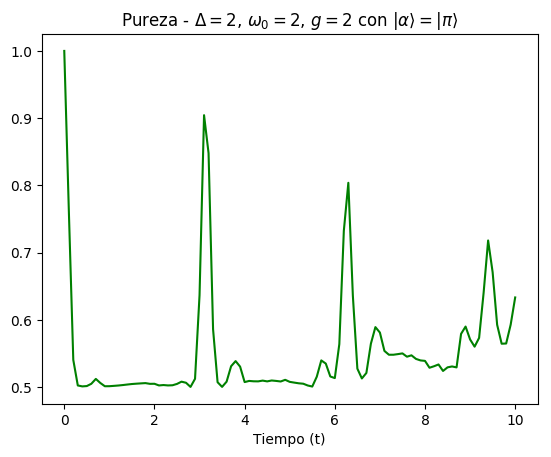

In [17]:
listt = 0:0.1:10
plot(listt,pureza1.(listt),color="green")
xlabel("Tiempo (t)")
title(L"Pureza - $\Delta=2$, $\omega_{0}=2$, $g=2$ con $\left|\alpha\right>=\left|\pi\right>$");

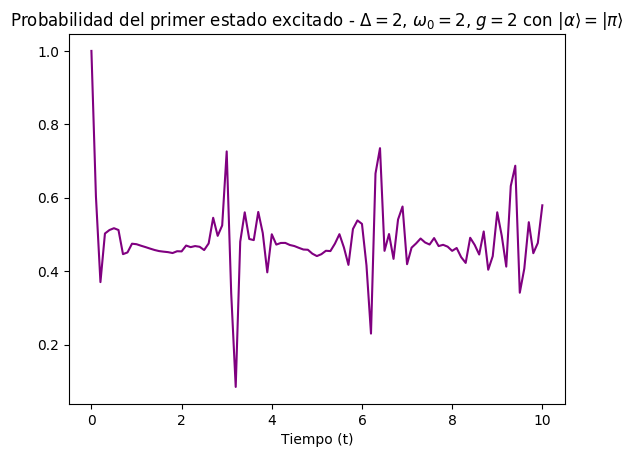

In [18]:
plot(listt,proba1.(listt),color="purple")
xlabel("Tiempo (t)")
title(L"Probabilidad del primer estado excitado - $\Delta=2$, $\omega_{0}=2$, $g=2$ con $\left|\alpha\right>=\left|\pi\right>$");

De esta gráfica notamos que la evolución temporal de la probabilidad de mantener el primer estado excitado decae casi instantáneamente a menos de la mitad, en caso de que dicho estado no se altere hasta aproximadamente 3 unidades de tiempo el sistema físico muestra que es baja la probabilidad de continuar en el primer estado excitado. Esto tiene sentido pues un sistema excitado tiende a volver a su estado base que es el de mínima energía. De aquí en adelante, no sabemos que decir sobre el sistema.

## Otros casos

En lo anterior se implementaron las rutinas para el sistema espín-boson y se obtuvo la pureza y la probabilidad de que el qubit se encuentre en el primer estado excitado para una frecuencia del qubit, frecuencia del campo y acoplamiento igual a 2, y con el estado coherente $\left|\pi\right>$. Ahora se hace para otros casos:

* $\Delta=10$, $\omega_{0}=1$, $g=1$ y $\left|\alpha\right>=\left|\pi\right>$

In [19]:
H2 = Hsp(100,10,1,1);   # Hamiltoniano

In [20]:
psi2(t) = state(H2,pi,t);   # Estado del sistema al tiempo t

In [21]:
rhos2(t) = partial_trace(psi2,t);   # Matriz de densidad reducida

In [22]:
pureza2(t) = pp(rhos2,t)[1];   # Pureza

In [23]:
proba2(t) = pp(rhos2,t)[2];   # Probabilidad de que el qubit se encuentre en el primer estado excitado

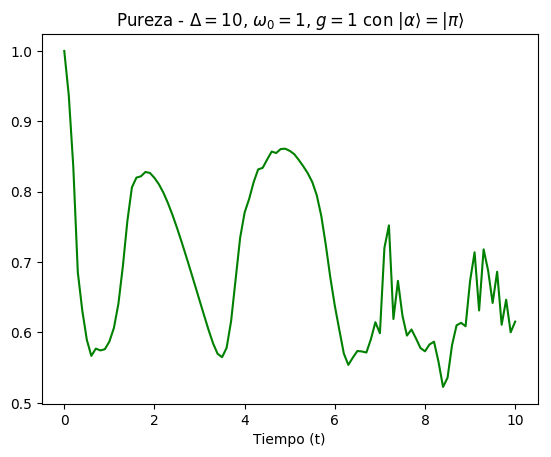

In [24]:
listt = 0:0.1:10
plot(listt,pureza2.(listt),color="green")
xlabel("Tiempo (t)")
title(L"Pureza - $\Delta=10$, $\omega_{0}=1$, $g=1$ con $\left|\alpha\right>=\left|\pi\right>$");

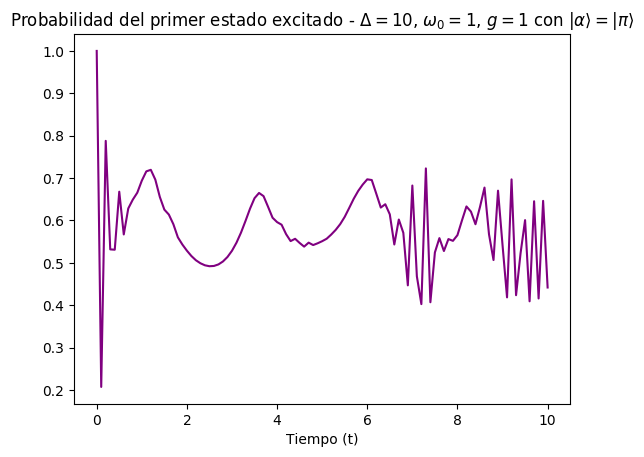

In [25]:
plot(listt,proba2.(listt),color="purple")
xlabel("Tiempo (t)")
title(L"Probabilidad del primer estado excitado - $\Delta=10$, $\omega_{0}=1$, $g=1$ con $\left|\alpha\right>=\left|\pi\right>$");

Notamos que en este caso la probabilidad de que se mantenga en el primer excitado decae rápidamente y en dado caso de que esto no suceda la probabilidad se mantiene oscilando alrededor del 50%.

* $\Delta=5$, $\omega_{0}=20$, $g=10$ y $\left|\alpha\right>=\left|6\right>$

In [26]:
H3 = Hsp(80,5,20,10);               # Hamiltoniano
psi3(t) = state(H3,6.0,t);          # Estado del sistema al tiempo t
rhos3(t) = partial_trace(psi3,t);   # Matriz de densidad reducida
pureza3(t) = pp(rhos3,t)[1];        # Pureza
proba3(t) = pp(rhos3,t)[2];         # Probabilidad de que el qubit se encuentre en el primer estado excitado

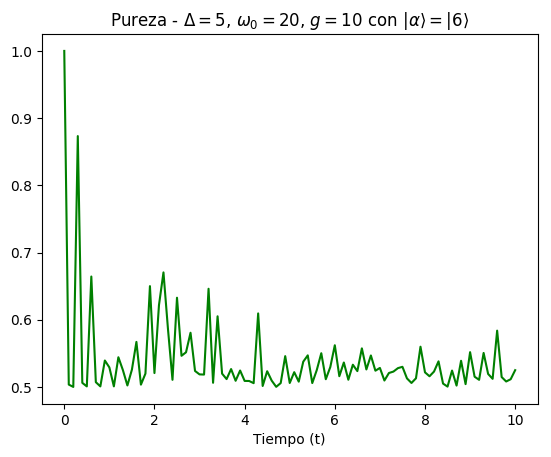

In [27]:
listt = 0:0.1:10
plot(listt,pureza3.(listt),color="green")
xlabel("Tiempo (t)")
title(L"Pureza - $\Delta=5$, $\omega_{0}=20$, $g=10$ con $\left|\alpha\right>=\left|6\right>$");

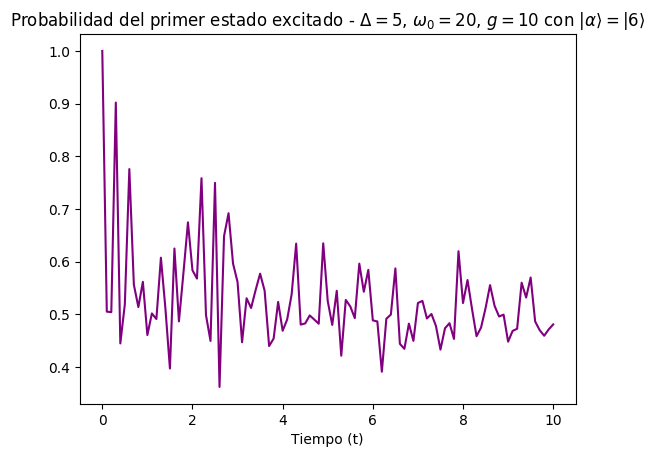

In [28]:
plot(listt,proba3.(listt),color="purple")
xlabel("Tiempo (t)")
title(L"Probabilidad del primer estado excitado - $\Delta=5$, $\omega_{0}=20$, $g=10$ con $\left|\alpha\right>=\left|6\right>$");

En estas dos últimas gráficas observamos que la evolución temporal de las probabilidades no proporciona información clara sobre el comportamiento del primer estado.

FIN